Code adapted from: https://github.com/ahmetumutdurmus/zaremba/blob/master/main.py

See also relevant paper: https://arxiv.org/pdf/1409.2329.pdf)

**Imports**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import numpy as np
from google.colab import drive
drive.mount('Google_drive')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print("We're using", device)

Mounted at Google_drive
We're using cuda


**Pre-processing**

In [2]:
# Define data loaders
def data_load():
    with open("/content/Google_drive/MyDrive/Deep Learning/Hw/ex2_303142897_206295917/PTB/train/ptb.train.txt") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("/content/Google_drive/MyDrive/Deep Learning/Hw/ex2_303142897_206295917/PTB/valid/ptb.valid.txt") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("/content/Google_drive/MyDrive/Deep Learning/Hw/ex2_303142897_206295917/PTB/test/ptb.test.txt") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return np.array(trn).reshape(-1, 1), np.array(vld).reshape(-1, 1), np.array(tst).reshape(-1, 1), len(words)

# Create minibatches of the data
def minibatch(data, batch_size, seq_length):
    data = torch.tensor(data, dtype = torch.int64)
    num_batches = data.size(0)//batch_size
    data = data[:num_batches*batch_size]
    data=data.view(batch_size,-1)
    dataset = []
    for i in range(0,data.size(1)-1,seq_length):
        seqlen=int(np.min([seq_length,data.size(1)-1-i]))
        if seqlen<data.size(1)-1-i:
            x=data[:,i:i+seqlen].transpose(1, 0)
            y=data[:,i+1:i+seqlen+1].transpose(1, 0)
            dataset.append((x, y))
    return dataset    

**Verify data source from Google drive**

In [3]:
# verify data location
%ls Google_drive/MyDrive/'Deep Learning'/Hw/ex2_303142897_206295917/PTB/train/ptb.train.txt
!realpath Google_drive/MyDrive/'Deep Learning'/Hw/ex2_303142897_206295917/PTB/train/ptb.train.txt
train, validation, test, words_len = data_load()
print(words_len)

'Google_drive/MyDrive/Deep Learning/Hw/ex2_303142897_206295917/PTB/train/ptb.train.txt'
/content/Google_drive/MyDrive/Deep Learning/Hw/ex2_303142897_206295917/PTB/train/ptb.train.txt
10000


In [4]:
#Embedding module
class Embed(nn.Module): #embedding is efficient when we have a large number of input features
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.W = nn.Parameter(torch.Tensor(vocab_size, embed_size))

    def forward(self, x):
        return self.W[x]

    def __repr__(self):
        return "Embedding(vocab: {}, embedding: {})".format(self.vocab_size, self.embed_size)

class Linear(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b = nn.Parameter(torch.Tensor(hidden_size))

    def forward(self, x):
        z = torch.addmm(self.b, x.view(-1, x.size(2)), self.W.t())
        return z

    def __repr__(self):
        return "FC(input: {}, output: {})".format(self.input_size, self.hidden_size)

class Model(nn.Module):
    def __init__(self, vocab_size, hidden_size, layer_num, dropout, winit, base):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.winit = winit
        self.embed = Embed(vocab_size, hidden_size)
        if base == 'gru':
          self.rnns = [nn.GRU(hidden_size, hidden_size) for i in range(layer_num)] #two GRU layers with 200 units per layer
        else:
          self.rnns = [nn.LSTM(hidden_size, hidden_size) for i in range(layer_num)] #two LSTM layers with 200 units per layer
        self.rnns = nn.ModuleList(self.rnns)
        self.fc = Linear(hidden_size, vocab_size) 
        self.dropout = nn.Dropout(p=dropout)
        self.reset_parameters() #weights are reset uniformly when initializing the model
        
    def reset_parameters(self): #LSTM hidden layers weights initialized uniformly between -0.1 to 0.1
        for param in self.parameters():
            nn.init.uniform_(param, -self.winit, self.winit) 
            
    def state_init(self, batch_size,base): #hidden states are initialized to zero, input of gru is h_0 and input of lstm is (h_0, c_0) 
        dev = next(self.parameters()).device
        if base == 'gru':
          states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        else:
          states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev), torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        return states 

    # detach to complete truncated backpropagation through time (BPTT)
    def detach(self, states, base):
      if base == 'lstm':
        return [(h.detach(), c.detach()) for (h,c) in states] # returns tensors that don't require a gradient
      else:
        return [h.detach() for h in states] #gru layers input of shape h_0

    def forward(self, x, states):
        x = self.embed(x)
        x = self.dropout(x)
        for i, rnn in enumerate(self.rnns):
            x, states[i] = rnn(x, states[i])
            x = self.dropout(x)
        scores = self.fc(x)
        return scores, states

In [5]:
def nll_loss(scores, y):
    batch_size = y.size(1)
    expscores = scores.exp()
    probabilities = expscores / expscores.sum(1, keepdim = True)
    answerprobs = probabilities[range(len(y.reshape(-1))), y.reshape(-1)]
    return torch.mean(-torch.log(answerprobs) * batch_size)


def perplexity(data,model,base):
  with torch.no_grad():
    losses = []
    states = model.state_init(20,base)
    for x,y in data:
      x, y = x.to(device), y.to(device)
      scores, states = model(x,states)
      loss = nll_loss(scores, y)
      losses.append(loss.data.item()/20)
    return np.exp(np.mean(losses))

In [8]:
def train_one_epoch(data, model, lr, max_norm,base, batch_size):
    trn, vld, tst = data
    total_words = 0
    states = model.state_init(batch_size, base) # batch size of 20 according to article
    model.train()
    for i, (x, y) in enumerate(trn):
        x, y = x.to(device), y.to(device)
        total_words += x.numel()
        model.zero_grad()
        states = model.detach(states, base)
        scores, states = model(x, states)
        loss = nll_loss(scores, y)
        loss.backward()
        with torch.no_grad():
            norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            for param in model.parameters():
                param -= lr * param.grad
        if i % (len(trn)//10) == 0:
            print("batch no = {:d} / {:d}, ".format(i, len(trn)) +
                  "train loss = {:.3f}, ".format(loss.item()/batch_size) + #calculate loss
                  "lr = {:.3f}, ".format(lr))
    model.eval()
    val_perp = perplexity(vld, model,base)
    print("Validation set perplexity : {:.3f}".format(val_perp))
    print("*************************************************\n")
    return val_perp

In [10]:
def main(data,epochs,epoch_threshold,lr,model,model_name,base,lr_factor, batch_size, seq_length, max_norm):
  train, validation, test, word_len = data_load()
  train = minibatch(train,batch_size, seq_length)
  validation = minibatch(validation, batch_size, seq_length)
  test = minibatch(test,batch_size, seq_length)
  output_data = {"model": model_name,
                 "train_perp": [],
                 "test_perp":[],
                 "val_perp":[]
                 }
  best_perp = np.Inf
  for epoch in range(1, epochs + 1):
      if epoch > epoch_threshold: 
        lr = lr / lr_factor # after epoch threshold, learning rate decreased by a factor for each epoch
      print(f'Epoch {epoch}/{epochs}')
      val_perp = train_one_epoch((train,validation,test), model,lr, max_norm ,base, batch_size)   
      model.eval()   
      test_perp = perplexity(test, model,base)
      train_perp = perplexity(train, model,base)
      output_data["train_perp"].append(train_perp)
      output_data["test_perp"].append(test_perp)
      output_data["val_perp"].append(val_perp)
      filename = model_name + '.json'
      if test_perp < best_perp:
        state = {
                'model': model.state_dict(),
                'train_perp': train_perp,
                'test_perp': test_perp,
                'epoch': epoch,
                }
        best_perp = test_perp
        torch.save(state, model_name + '.pt')
        with open(filename, 'w', encoding='utf-8') as f:
          json.dump(output_data, f, indent=4)
      print("Test set perplexity : {:.3f}".format(test_perp))
      print("Training over")



In [11]:
# Running LSTM model without dropout
batch_size = 20
seq_length = 20
base = 'lstm'

train, validation, test, words_len = data_load()
train = minibatch(train, batch_size, seq_length)
validation = minibatch(validation, batch_size, seq_length)
test = minibatch(test, batch_size, seq_length)

hidden_size = 200
layer_num = 2
dropout = 0
w_init = 0.1

model_lstm = Model(words_len, hidden_size, layer_num, dropout, w_init, base) #LSTM model without dropout
model_lstm.to(device)

num_epochs = 13
epoch_threshold = 4
lr = 1
model_name = "LSTM"
lr_factor = 2
max_norm = 5

main((train,validation,test), num_epochs, epoch_threshold, lr,model_lstm, model_name, base, lr_factor, batch_size, seq_length, max_norm)


Epoch 1/13
batch no = 0 / 2323, train loss = 9.223, lr = 1.000, 
batch no = 232 / 2323, train loss = 6.282, lr = 1.000, 
batch no = 464 / 2323, train loss = 5.981, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.749, lr = 1.000, 
batch no = 928 / 2323, train loss = 5.272, lr = 1.000, 
batch no = 1160 / 2323, train loss = 5.411, lr = 1.000, 
batch no = 1392 / 2323, train loss = 5.572, lr = 1.000, 
batch no = 1624 / 2323, train loss = 5.182, lr = 1.000, 
batch no = 1856 / 2323, train loss = 4.930, lr = 1.000, 
batch no = 2088 / 2323, train loss = 5.500, lr = 1.000, 
batch no = 2320 / 2323, train loss = 5.341, lr = 1.000, 
Validation set perplexity : 185.841
*************************************************

Test set perplexity : 184.766
Training over
Epoch 2/13
batch no = 0 / 2323, train loss = 5.715, lr = 1.000, 
batch no = 232 / 2323, train loss = 5.033, lr = 1.000, 
batch no = 464 / 2323, train loss = 5.067, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.032, lr = 1.000, 
batch

In [12]:
# Running LSTM model with 30% dropout
batch_size = 20
seq_length = 20
base = 'lstm'

train, validation, test, words_len = data_load()

hidden_size = 200
layer_num = 2
dropout = 0.3
w_init = 0.1

model_lstm_dropout = Model(words_len, hidden_size, layer_num , dropout, w_init, base) #LSTM model with 30% dropout
model_lstm_dropout.to(device)

num_epochs = 25
epoch_threshold = 8
lr = 1
model_name = "LSTM_dropout"
lr_factor = 1.5
max_norm = 5

main((train,validation,test), num_epochs, epoch_threshold, lr, model_lstm_dropout, model_name, base, lr_factor, batch_size, seq_length, max_norm)

Epoch 1/25
batch no = 0 / 2323, train loss = 9.221, lr = 1.000, 
batch no = 232 / 2323, train loss = 6.311, lr = 1.000, 
batch no = 464 / 2323, train loss = 6.043, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.831, lr = 1.000, 
batch no = 928 / 2323, train loss = 5.423, lr = 1.000, 
batch no = 1160 / 2323, train loss = 5.533, lr = 1.000, 
batch no = 1392 / 2323, train loss = 5.674, lr = 1.000, 
batch no = 1624 / 2323, train loss = 5.329, lr = 1.000, 
batch no = 1856 / 2323, train loss = 5.106, lr = 1.000, 
batch no = 2088 / 2323, train loss = 5.687, lr = 1.000, 
batch no = 2320 / 2323, train loss = 5.521, lr = 1.000, 
Validation set perplexity : 196.468
*************************************************

Test set perplexity : 193.867
Training over
Epoch 2/25
batch no = 0 / 2323, train loss = 5.872, lr = 1.000, 
batch no = 232 / 2323, train loss = 5.220, lr = 1.000, 
batch no = 464 / 2323, train loss = 5.260, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.176, lr = 1.000, 
batch

In [14]:
# Running GRU model without dropout
batch_size = 20
seq_length = 20
base = 'gru'

hidden_size = 200
layer_num = 2
dropout = 0
w_init = 0.1

model_gru = Model(words_len, hidden_size, layer_num, dropout, w_init, base) #GRU model no dropout
model_gru.to(device)

num_epochs = 20
epoch_threshold = 4
lr = 0.4
model_name = "GRU"
lr_factor = 1.9
max_norm = 5
main((train,validation,test), num_epochs, epoch_threshold, lr, model_gru, model_name, base, lr_factor, batch_size, seq_length, max_norm)

Epoch 1/20
batch no = 0 / 2323, train loss = 9.222, lr = 0.400, 
batch no = 232 / 2323, train loss = 6.375, lr = 0.400, 
batch no = 464 / 2323, train loss = 6.030, lr = 0.400, 
batch no = 696 / 2323, train loss = 5.783, lr = 0.400, 
batch no = 928 / 2323, train loss = 5.337, lr = 0.400, 
batch no = 1160 / 2323, train loss = 5.417, lr = 0.400, 
batch no = 1392 / 2323, train loss = 5.580, lr = 0.400, 
batch no = 1624 / 2323, train loss = 5.221, lr = 0.400, 
batch no = 1856 / 2323, train loss = 5.026, lr = 0.400, 
batch no = 2088 / 2323, train loss = 5.488, lr = 0.400, 
batch no = 2320 / 2323, train loss = 5.371, lr = 0.400, 
Validation set perplexity : 193.014
*************************************************

Test set perplexity : 189.435
Training over
Epoch 2/20
batch no = 0 / 2323, train loss = 5.878, lr = 0.400, 
batch no = 232 / 2323, train loss = 5.068, lr = 0.400, 
batch no = 464 / 2323, train loss = 5.029, lr = 0.400, 
batch no = 696 / 2323, train loss = 5.015, lr = 0.400, 
batch

In [15]:
# Running GRU model with 40% dropout
batch_size = 20
seq_length = 20
base = 'gru'

hidden_size = 200
layer_num = 2
dropout = 0.4
w_init = 0.1

model_gru_dropout = Model(words_len, hidden_size, layer_num, dropout, w_init, base) #GRU model 40% dropout
model_gru_dropout.to(device)

num_epochs = 50
epoch_threshold = 15
lr = 0.5
model_name = "GRU_dropout"
lr_factor = 1.2

main((train,validation,test), num_epochs, epoch_threshold, lr, model_gru_dropout, model_name,base, lr_factor, batch_size, seq_length, max_norm)

Epoch 1/50
batch no = 0 / 2323, train loss = 9.214, lr = 0.500, 
batch no = 232 / 2323, train loss = 6.537, lr = 0.500, 
batch no = 464 / 2323, train loss = 6.132, lr = 0.500, 
batch no = 696 / 2323, train loss = 6.020, lr = 0.500, 
batch no = 928 / 2323, train loss = 5.551, lr = 0.500, 
batch no = 1160 / 2323, train loss = 5.634, lr = 0.500, 
batch no = 1392 / 2323, train loss = 5.716, lr = 0.500, 
batch no = 1624 / 2323, train loss = 5.527, lr = 0.500, 
batch no = 1856 / 2323, train loss = 5.243, lr = 0.500, 
batch no = 2088 / 2323, train loss = 5.806, lr = 0.500, 
batch no = 2320 / 2323, train loss = 5.712, lr = 0.500, 
Validation set perplexity : 220.284
*************************************************

Test set perplexity : 215.622
Training over
Epoch 2/50
batch no = 0 / 2323, train loss = 6.022, lr = 0.500, 
batch no = 232 / 2323, train loss = 5.407, lr = 0.500, 
batch no = 464 / 2323, train loss = 5.385, lr = 0.500, 
batch no = 696 / 2323, train loss = 5.375, lr = 0.500, 
batch

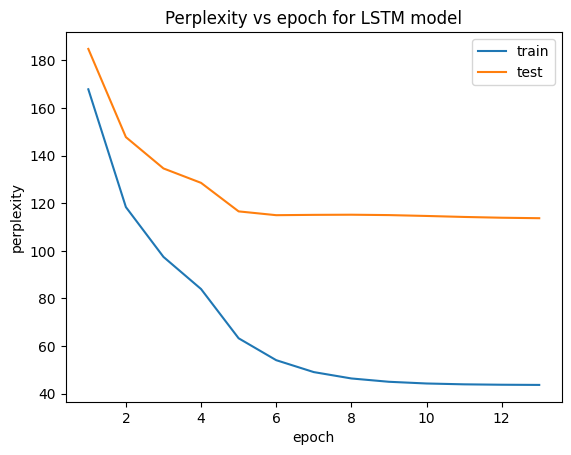

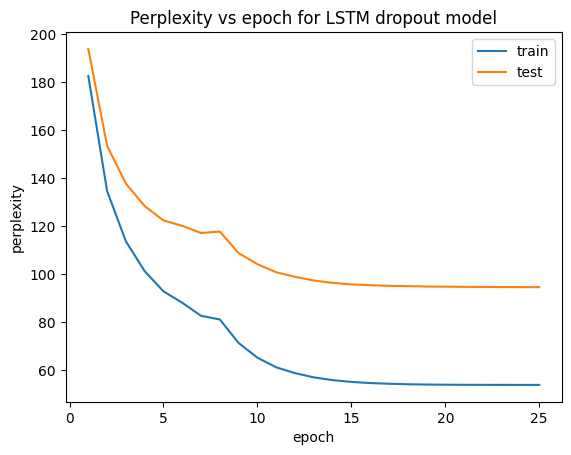

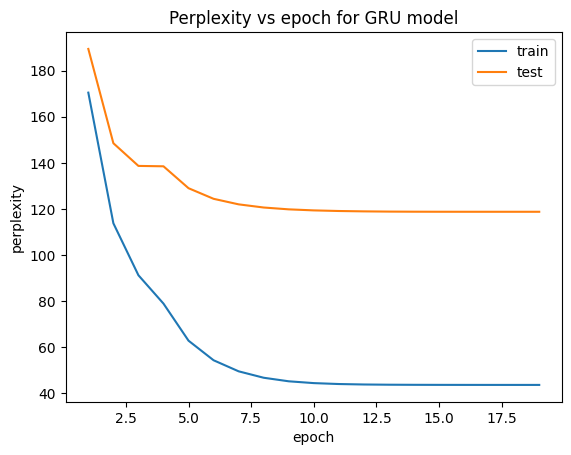

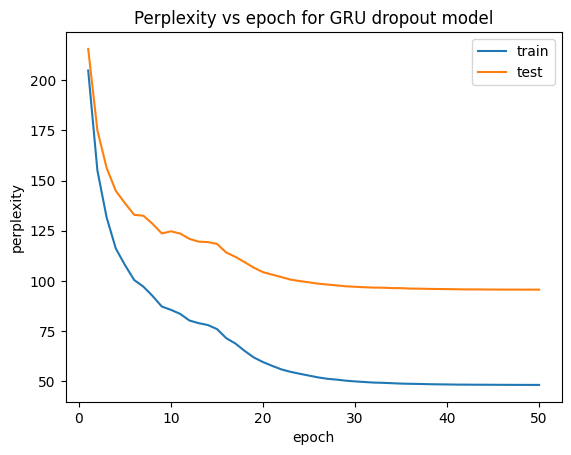

In [16]:
#plot perplexity vs epoch of test and train data from json files
summary = {'LSTM Model' : [],
           'LSTM Dropout Model': [],
           'GRU Model': [],
           'GRU Dropout Model':[]}
with open('LSTM.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_regular_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for LSTM model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_regular_model.savefig('LSTM_perplexity_plot.png')
plt.show()
summary['LSTM Model'].append(min(results_dict['train_perp']))
summary['LSTM Model'].append(min(results_dict['test_perp']))
summary['LSTM Model'].append(min(results_dict['val_perp']))

with open('LSTM_dropout.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_dropout_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for LSTM dropout model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_dropout_model.savefig('LSTM_dropout_perplexity_plot.png')
plt.show()
summary['LSTM Dropout Model'].append(min(results_dict['train_perp']))
summary['LSTM Dropout Model'].append(min(results_dict['test_perp']))
summary['LSTM Dropout Model'].append(min(results_dict['val_perp']))

with open('GRU.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_wd_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for GRU model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_wd_model.savefig('GRU_perplexity_plot.png')
plt.show()
summary['GRU Model'].append(min(results_dict['train_perp']))
summary['GRU Model'].append(min(results_dict['test_perp']))
summary['GRU Model'].append(min(results_dict['val_perp']))

with open('GRU_dropout.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_bn_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for GRU dropout model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_bn_model.savefig('GRU_dropout_perplexity_plot.png')
plt.show()
summary['GRU Dropout Model'].append(min(results_dict['train_perp']))
summary['GRU Dropout Model'].append(min(results_dict['test_perp']))
summary['GRU Dropout Model'].append(min(results_dict['val_perp']))

In [17]:
print("{:<20} {:<20} {:<20} {:<20}".format('MODEL', 'VALIDATION', 'TRAIN', 'TEST'))
 
#print max train and test accuracy for each model, summarize in a table
for key, value in summary.items():
    train,test,val = value
    print("{:<20} {:<20} {:<20} {:<20}".format(key, val, train, test))

MODEL                VALIDATION           TRAIN                TEST                
LSTM Model           117.55855439700146   43.7041202800996     113.69518918580192  
LSTM Dropout Model   98.84896458605425    53.89457242217583    94.62093556488331   
GRU Model            122.83624405544253   43.67377965259323    118.7865216049553   
GRU Dropout Model    99.06497976474513    48.13819720721924    95.6290303721404    
